In [1]:
import matplotlib.pyplot as plt

from scripts import tabular_baselines

import seaborn as sns
import numpy as np

from datasets import load_openml_list, valid_dids_classification, test_dids_classification, open_cc_dids
from scripts.tabular_baselines import *
from scripts.tabular_evaluation import evaluate
from scripts.tabular_metrics import calculate_score, make_ranks_and_wins_table, make_metric_matrix
from scripts import tabular_metrics
from scripts.transformer_prediction_interface import TabPFNClassifier

/anaconda/envs/fresh311/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
from notebook_utils import *

In [3]:
%load_ext autoreload

%autoreload 2

# Datasets

In [4]:
from datasets import load_openml_list, open_cc_dids, open_cc_valid_dids, test_dids_classification

cc_test_datasets_multiclass, cc_test_datasets_multiclass_df = load_openml_list(open_cc_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = 10000, num_feats=100, return_capped=True)


Number of datasets: 30


# Setting params

In [5]:
import os
eval_positions = [1000]
max_features = 100
n_samples = 2000
base_path = os.path.join('.')
overwrite = False
#max_times = [0.5, 1, 15, 30, 60, 60*5, 60*15, 60*60]
#max_times = [1, 15]
max_times = [1, 15, 30, 60, 60 * 5, 60 * 15, 60*60]
metric_used = tabular_metrics.auc_metric
task_type = 'multiclass'

In [6]:
from scripts.distill_mlp import DistilledTabPFNMLP
from tabpfn.transformer_make_model import PermutationsMeta, MotherNetClassifier
from functools import partial
from scripts.tabular_baselines import knn_metric, catboost_metric, transformer_metric, logistic_metric, xgb_metric, random_forest_metric, mlp_metric


# Baseline Evaluation
This section runs baselines and saves results locally.

In [7]:
!mkdir -p {base_path}/results
!mkdir -p {base_path}/results/tabular/
!mkdir -p {base_path}/results/tabular/multiclass/

In [8]:
cc_test_datasets_multiclass_df['isNumeric'] = (cc_test_datasets_multiclass_df.NumberOfSymbolicFeatures == 1) & (cc_test_datasets_multiclass_df.NumberOfInstancesWithMissingValues == 0)
name_indexed_dataset = cc_test_datasets_multiclass_df.set_index("name")

numeric_test_datasets = [ds for ds in cc_test_datasets_multiclass if name_indexed_dataset.loc[ds[0]].isNumeric]
len(numeric_test_datasets)

18

In [9]:
cc_test_datasets_multiclass_df['NumberOfInstances'] =  cc_test_datasets_multiclass_df['NumberOfInstances'].astype(int)
cc_test_datasets_multiclass_df['NumberOfFeatures'] =  cc_test_datasets_multiclass_df['NumberOfFeatures'].astype(int)
cc_test_datasets_multiclass_df['NumberOfClasses'] =  cc_test_datasets_multiclass_df['NumberOfClasses'].astype(int)

print(cc_test_datasets_multiclass_df[cc_test_datasets_multiclass_df.isNumeric][['did', 'name', 'NumberOfFeatures', 'NumberOfInstances', 'NumberOfClasses']].to_latex(index=False))

\begin{tabular}{rlrrr}
\toprule
  did &                             name &  NumberOfFeatures &  NumberOfInstances &  NumberOfClasses \\
\midrule
   11 &                    balance-scale &                 5 &                625 &                3 \\
   14 &                    mfeat-fourier &                77 &               2000 &               10 \\
   16 &                   mfeat-karhunen &                65 &               2000 &               10 \\
   18 &              mfeat-morphological &                 7 &               2000 &               10 \\
   22 &                    mfeat-zernike &                48 &               2000 &               10 \\
   37 &                         diabetes &                 9 &                768 &                2 \\
   54 &                          vehicle &                19 &                846 &                4 \\
  458 &           analcatdata\_authorship &                71 &                841 &                4 \\
 1049 &               

/tmp/ipykernel_2375413/28758530.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(cc_test_datasets_multiclass_df[cc_test_datasets_multiclass_df.isNumeric][['did', 'name', 'NumberOfFeatures', 'NumberOfInstances', 'NumberOfClasses']].to_latex(index=False))


In [10]:
import os
os.environ["LD_LIBRARY_PATH"] = "/anaconda/envs/fresh311/lib:" + os.environ["LD_LIBRARY_PATH"]

In [11]:
from tabpfn.scripts.tabular_evaluation import eval_on_datasets
max_times = [1, 5, 15, 60, 5 * 60, 15 * 60, 60* 60]
# these will all be evaluated on CPU because they are given as  callables, which is a weird way to do it.
clf_dict= {
    'knn': knn_metric,
    'rf_new_params': random_forest_metric,
    'xgb': xgb_metric,
    'logistic': logistic_metric,
    'mlp': mlp_metric}

results_baselines = [
    eval_on_datasets('multiclass', model, model_name, numeric_test_datasets, eval_positions=eval_positions, max_times=max_times,
                     metric_used=metric_used, split_numbers=[1, 2, 3, 4, 5],
                     n_samples=n_samples, base_path=base_path)
    for model_name, model in clf_dict.items()
]

evaluating knn on cpu


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
/anaconda/envs/fresh311/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/anaconda/envs/fresh311/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorc

evaluating rf_new_params on cpu


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating xgb on cpu


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating logistic on cpu


[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 439 out of 630 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating mlp on cpu


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 439 out of 630 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    0.6s finished


In [12]:
from tabpfn.scripts.tabular_evaluation import eval_on_datasets
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from tabpfn.transformer_make_model import ShiftClassifier, EnsembleMeta, MotherNetClassifier

# transformers don't have max times
import warnings
max_times = [1]
device = "cpu"

model_string = "defaults_k_aggregate_2_batch_128_onehot_classes_multiclass_02_10_2023_23_55_16"
tabpfn_mine =  TabPFNClassifier(device=device, model_string=model_string, epoch=82, N_ensemble_configurations=32)
#tabpfn_refactor = TabPFNClassifier(device=device, model_string="vanilla_lr0001_new_05_31_2023_23_16_43", epoch=200, N_ensemble_configurations=32)
#tabpfn_refactor_epoch_290 = TabPFNClassifier(device=device, model_string="vanilla_lr0001_new_05_31_2023_23_16_43", epoch=290, N_ensemble_configurations=32)

distilled_tabpfn = DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, )
distilled_tabpfn_one_layer = make_pipeline(StandardScaler(),DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=1, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, ))
distilled_tabpfn_one_layer_no_dropout = make_pipeline(StandardScaler(),DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=1, dropout_rate=0, learning_rate=0.01, model_string=model_string, epoch=82, ))
distilled_tabpfn_two_layer_reproduce2 = make_pipeline(StandardScaler(), DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, ))
distilled_tabpfn_one_layer_512_no_dropout = make_pipeline(StandardScaler(),DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=512, n_layers=1, learning_rate=0.001, model_string=model_string, epoch=82, ))
distilled_tabpfn_two_layer_512_no_dropout = make_pipeline(StandardScaler(),DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=512, n_layers=2, learning_rate=0.001, model_string=model_string, epoch=82, ))

distilled_tabpfn_two_layer_reproduce_gpu = make_pipeline(StandardScaler(), DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, ))
distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3 = make_pipeline(StandardScaler(), DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, N_ensemble_configurations=3))
distilled_tabpfn_two_layer_reproduce_cpu_ensemble_3 = make_pipeline(StandardScaler(), DistilledTabPFNMLP(n_epochs=1000, device="cpu", hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, N_ensemble_configurations=3))



mother_model_string = "models_diff/prior_diff_real_checkpointcontinue_hidden_128_embed_dim_1024_decoder_nhid_2048_nlayer12_lr0003_n_0_epoch_65.cpkt"
forward_mlp = PermutationsMeta(MotherNetClassifier(path=mother_model_string, device=device))
mothernet_new = PermutationsMeta(MotherNetClassifier(path='models_diff/prior_diff_real_checkpointcontinue_hidden_128_embed_dim_1024_decoder_nhid_2048_nlayer12_lr0003_n_0_epoch_on_exit.cpkt'))
mothernet_new_again = PermutationsMeta(MotherNetClassifier(path='models_diff/mothernet_from_scratch_again_06_28_2023_20_51_25_epoch_on_exit.cpkt'))

mothernet_big_model_string = "models_diff/prior_diff_real_checkpointwarm_start_depth_18_model_maker_lr0003_multiclass_05_30_2023_22_53_04_n_0_epoch_49.cpkt"
mothernet_big = PermutationsMeta(MotherNetClassifier(path=mothernet_big_model_string, device=device))

model_string_post_refactor = "models_diff/prior_diff_real_checkpointmothernet_from_scratch_lr0003_warm_start_continue2_multiclass_05_31_2023_19_21_34_n_0_epoch_94.cpkt"
mothernet_post_refactor = PermutationsMeta(MotherNetClassifier(path=model_string_post_refactor, device=device))

model_string_mothernet_small_batches = "models_diff/mothernet_512_everywhere_steps_1024_batch_16_07_02_2023_17_29_55_epoch_on_exit.cpkt"
mothernet_small_batches = PermutationsMeta(MotherNetClassifier(path=model_string_mothernet_small_batches, device=device))


model_string_old_reference_config = "reproduce_reference_config_06_02_2023_17_08_59"
old_reference_config = TabPFNClassifier(device=device, model_string=model_string_old_reference_config, epoch="on_exit", N_ensemble_configurations=32)
old_reference_config_epoch_290 = TabPFNClassifier(device=device, model_string=model_string_old_reference_config, epoch=290, N_ensemble_configurations=32)

model_string_reference_config_continue =  "reproduce_reference_config_continue_06_05_2023_17_45_06"
reference_config_continue = TabPFNClassifier(device=device, model_string=model_string_reference_config_continue, epoch="on_exit", N_ensemble_configurations=32)



model_string_reference_config_long = "reproduce_reference_config_try_again_800_epochs_06_07_2023_21_49_10"
reference_config_long = TabPFNClassifier(device=device, model_string=model_string_reference_config_long, epoch="on_exit", N_ensemble_configurations=32)

perceiver_long = MotherNetClassifier(path="models_diff/perceiver_output_128_emsize_512_nlayers_12_steps_1024_07_01_2023_17_56_04_epoch_690.cpkt", device=device)
perceiver_long_permutations = PermutationsMeta(perceiver_long)

model_string_newest_mlflow = "models_diff/mothernet_128_decoder_1024_emsize_512_nlayers_12_steps_1024_bs_32a_lr_0.0001_1_gpu_07_19_2023_04_54_38_epoch_1350.cpkt"
mothernet_mlflow_04_54_38 = PermutationsMeta(MotherNetClassifier(path=model_string_newest_mlflow, device=device))

model_string_newest_mlflow_1750 = "models_diff/mothernet_128_decoder_1024_emsize_512_nlayers_12_steps_1024_bs_32a_lr_0.0001_1_gpu_07_19_2023_04_54_38_epoch_1750.cpkt"
mothernet_mlflow_04_54_38_e1750 = PermutationsMeta(MotherNetClassifier(path=model_string_newest_mlflow_1750, device=device))
mothernet_mlflow_04_54_38_e1750_ensemble = EnsembleMeta(MotherNetClassifier(path=model_string_newest_mlflow_1750, device=device))


#mothernet_tabpfn_preprocessing =  TabPFNClassifier(device=device, model_string="mothernet_128_decoder_1024_emsize_512_nlayers_12_steps_1024_bs_32a_lr_0.0001_1_gpu_07_19_2023_04_54_38", epoch="1350", N_ensemble_configurations=32)

mothernet_new_old_tabpfn_preprocessing =  TabPFNClassifier(device=device, model_string="prior_diff_real_checkpointcontinue_hidden_128_embed_dim_1024_decoder_nhid_2048_nlayer12_lr0003_n_0", epoch="on_exit", N_ensemble_configurations=32)
mothernet_new_old_ensemble =  EnsembleMeta(MotherNetClassifier(device=device, path="models_diff/prior_diff_real_checkpointcontinue_hidden_128_embed_dim_1024_decoder_nhid_2048_nlayer12_lr0003_n_0_epoch_on_exit.cpkt"), n_estimators=32)

#mothernet_1750_tabpfn_preprocessing =  TabPFNClassifier(device=device, model_string="mothernet_128_decoder_1024_emsize_512_nlayers_12_steps_1024_bs_32a_lr_0.0001_1_gpu_07_19_2023_04_54_38", epoch="1750", N_ensemble_configurations=32)


perceiver_16_19_18_ensemble =  EnsembleMeta(MotherNetClassifier(device=device, path="models_diff/perceiver_128_emsize_512_nlayers_12_steps_4096_batch_64_lr_3e-05_one_gpu_07_11_2023_16_19_18_epoch_1120.cpkt"), n_estimators=32)

mlflow_validate_str = "tabpfn_128_decoder_1024_emsize_512_nlayers_12_steps_1024_bs_8ada_lr_3e-05_1_gpu_07_21_2023_21_58_32"
mlflow_validate_tabpfn = TabPFNClassifier(device=device, model_string=mlflow_validate_str, epoch="1470", N_ensemble_configurations=32)

#mother_of_ensembles = BaggingClassifier(PermutationsMeta(MotherNetClassifier(path=mother_model_string)), max_features=.8, max_samples=.8)
#mother_of_ensembles_again = BaggingClassifier(PermutationsMeta(MotherNetClassifier(path=mother_model_string)), max_features=.5, max_samples=.5)
forward_mlp_scaled = make_pipeline(StandardScaler(), forward_mlp)
distilled_tabpfn_scaled = make_pipeline(StandardScaler(), distilled_tabpfn)


new_tabpfn_long_e1020 = TabPFNClassifier(device=device, model_string="tabpfn__emsize_512_nlayers_12_steps_2048_bs_32ada_lr_0.0001_1_gpu_07_24_2023_01_43_33", epoch="1020", N_ensemble_configurations=32)
new_tabpfn_long_e1650_ensemble32 = TabPFNClassifier(device=device, model_string="tabpfn__emsize_512_nlayers_12_steps_2048_bs_32ada_lr_0.0001_1_gpu_07_24_2023_01_43_33", epoch="1650", N_ensemble_configurations=32)
new_tabpfn_long_e1650_ensemble3 = TabPFNClassifier(device=device, model_string="tabpfn__emsize_512_nlayers_12_steps_2048_bs_32ada_lr_0.0001_1_gpu_07_24_2023_01_43_33", epoch="1650", N_ensemble_configurations=3)


# large batchsize large learning rate
mothernet_old_config_repro_20_10_21_ensemble = EnsembleMeta(MotherNetClassifier(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_512_bs_8192_lr_0.0003_1_gpu_07_28_2023_20_10_21_epoch_2000.cpkt", device=device))
# small batchsize small learning rate
mothernet_new_config_04_14_37_ensemble_e1390 = EnsembleMeta(MotherNetClassifier(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_epoch_1390.cpkt", device=device)) 
mothernet_new_config_04_14_37_ensemble_e1520 = EnsembleMeta(MotherNetClassifier(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_epoch_1520.cpkt", device=device)) 

mothernet_01_07_16_e1560 = EnsembleMeta(MotherNetClassifier(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1560.cpkt", device=device))
mothernet_21_29_51_e5610 = EnsembleMeta(MotherNetClassifier(path="models_diff/mn_n1024_E8000_1_gpu_08_01_2023_21_29_51_epoch_5610.cpkt", device=device))

low_rank_48_19 = EnsembleMeta(MotherNetClassifier(path="models_diff/mn_n1024_L2_W128_P512_1_gpu_08_03_2023_03_48_19_epoch_on_exit.cpkt", device=device))
mothernet_L2_18_33_e780 = EnsembleMeta(MotherNetClassifier(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_31_2023_23_18_33_epoch_780.cpkt", device=device))

mothernet_15_46_11_e120 =  EnsembleMeta(MotherNetClassifier(path="models_diff/mn_d1024_H2048_l1e-06_b32_noprenormTrue_1_gpu_warm_08_13_2023_15_46_11_epoch_130.cpkt", device=device))
tabpfn_21_43_17_e760 =  TabPFNClassifier(model_string="tabpfn_n512_l1e-05_b32_mtabpfn_noprenormTrue_1_gpu_warm_08_11_2023_21_43_17", device=device, epoch=760, N_ensemble_configurations=32)
mothernet_01_07_16_e1720 = EnsembleMeta(MotherNetClassifier(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1720.cpkt", device=device))
mothernet_01_07_16_e1720_gpu = EnsembleMeta(MotherNetClassifier(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1720.cpkt", device=device))
mothernet_01_07_16_e1720_gpu_ensemble3 = EnsembleMeta(MotherNetClassifier(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1720.cpkt", device=device), n_estimators=3)
mothernet_01_07_16_e1720_cpu_ensemble3 = EnsembleMeta(MotherNetClassifier(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1720.cpkt", device="cpu"), n_estimators=3)
mothernet_01_07_16_e1720_gpu_ensemble3_gpu_inference = EnsembleMeta(MotherNetClassifier(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1720.cpkt", device=device, inference_device=device), n_estimators=3)
mothernet_05_25_46_e5900 = EnsembleMeta(MotherNetClassifier(path="models_diff/mn_n1024_E8000_d2048_H4096_L2_W128_P512_1_gpu_08_06_2023_05_25_46_epoch_5900.cpkt", device=device))
mothernet_L2_W128_05_25_46_e6550 = EnsembleMeta(MotherNetClassifier(path="models_diff/mn_n1024_E8000_d2048_H4096_L2_W128_P512_1_gpu_08_06_2023_05_25_46_epoch_6550.cpkt", device=device))

mothernet_21_46_25_3940_ensemble3 = EnsembleMeta(MotherNetClassifier(path="mn_d2048_H4096_L2_W32_P512_1_gpu_warm_08_25_2023_21_46_25_epoch_3940_no_optimizer.pickle", device=device), n_estimators=3)


# actually accidentally trained with false due to bug, even if config says true
#reference_config_long.model.efficient_eval_masking = False
clf_dict= {
    
     #        'transformer': transformer_metric,
            'transformer_gpu_timing': TabPFNClassifier(device=device, N_ensemble_configurations=3),
              # 'tabpfn_mine': partial(transformer_metric, classifier=tabpfn_mine),
             #  'tabpfn_post_mlflow': partial(transformer_metric, classifier=mlflow_validate_tabpfn),
          
        'mothernet_01_07_16_e1720_cpu_ensemble3_prescaling': mothernet_01_07_16_e1720_cpu_ensemble3,
    'new_tabpfn_long_e1650_ensemble32': new_tabpfn_long_e1650_ensemble32,
    'new_tabpfn_long_e1650_ensemble3': new_tabpfn_long_e1650_ensemble3,

    'distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3_fixed': distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3,
    'mothernet_01_07_16_e1720_gpu_ensemble3_gpu_inference_fixed': mothernet_01_07_16_e1720_gpu_ensemble3_gpu_inference,
      #  'mothernet_05_25_46_e5900': partial(transformer_metric, classifier=mothernet_05_25_46_e5900),
    #'distilled_tabpfn_two_layer_reproduce_cpu_ensemble_3': distilled_tabpfn_two_layer_reproduce_cpu_ensemble_3,
    #'mothernet_L2_W128_05_25_46_e6550': mothernet_L2_W128_05_25_46_e6550
        'mothernet_21_46_25_3940_ensemble3_onehot': partial(transformer_metric, classifier=mothernet_21_46_25_3940_ensemble3, onehot=True)


                  }
results_transformers = [
    eval_on_datasets('multiclass', model, model_name, numeric_test_datasets, eval_positions=eval_positions, max_times=max_times,
                     metric_used=metric_used, split_numbers=[1, 2, 3, 4, 5],
                     n_samples=n_samples, base_path=base_path, overwrite=False, n_jobs=-1)
    for model_name, model in clf_dict.items()
]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 out of  90 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  83 out of  90 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating transformer_gpu_timing on cpu
evaluating mothernet_01_07_16_e1720_cpu_ensemble3_prescaling on cpu


[Parallel(n_jobs=-1)]: Done  37 out of  90 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  83 out of  90 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 out of  90 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  83 out of  90 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating new_tabpfn_long_e1650_ensemble32 on cpu
evaluating new_tabpfn_long_e1650_ensemble3 on cpu


[Parallel(n_jobs=-1)]: Done  37 out of  90 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  83 out of  90 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 out of  90 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  83 out of  90 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 out of  90 | elapsed:    0.1s remaining:    0.1s


evaluating distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3_fixed on cpu
evaluating mothernet_01_07_16_e1720_gpu_ensemble3_gpu_inference_fixed on cpu


[Parallel(n_jobs=-1)]: Done  83 out of  90 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating mothernet_21_46_25_3940_ensemble3_onehot on cpu
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device


[Parallel(n_jobs=-1)]: Done  37 out of  90 | elapsed:   13.9s remaining:   19.9s


Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device


[Parallel(n_jobs=-1)]: Done  83 out of  90 | elapsed:   17.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   17.6s finished


In [13]:
# results_baselines = []

Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parame

In [14]:
flat_results = []
for per_dataset in results_baselines + results_transformers:
    for result in per_dataset:
        row = {}
        for key in ['dataset', 'model', 'mean_metric', 'split', 'max_time']:
            row[key] = result[key]
        best_configs_key, = [k for k in result.keys() if "best_configs" in k]
        if result[best_configs_key][0] is not None:
            row.update(result[best_configs_key][0])
        row['mean_metric'] = float(row["mean_metric"].numpy())
        flat_results.append(row)

results_df = pd.DataFrame(flat_results)

In [15]:
results_df

Using a Transformer with 149.66 M parameters
Using cpu:0 device


,dataset,model,mean_metric,split,max_time,best,fit_time,inference_time
0,balance-scale,knn,0.898451,1,1,{'n_neighbors': 14},0.000790,0.031152
1,balance-scale,knn,0.848925,2,1,{'n_neighbors': 8},0.000795,0.026842
2,balance-scale,knn,0.852651,3,1,{'n_neighbors': 10},0.000851,0.027301
3,balance-scale,knn,0.885874,4,1,{'n_neighbors': 10},0.000786,0.028868
4,balance-scale,knn,0.895205,5,1,{'n_neighbors': 15},0.000829,0.027410
...,...,...,...,...,...,...,...,...
3775,climate-model-simulation-crashes,mothernet_21_46_25_3940_ensemble3_onehot,0.948417,1,1,NaN,7.910175,0.021394
3776,climate-model-simulation-crashes,mothernet_21_46_25_3940_ensemble3_onehot,0.946664,2,1,NaN,8.375199,0.015274
3777,climate-model-simulation-crashes,mothernet_21_46_25_3940_ensemble3_onehot,0.938770,3,1,NaN,8.534508,0.015271
3778,climate-model-simulation-crashes,mothernet_21_46_25_3940_ensemble3_onehot,0.943767,4,1,NaN,8.166904,0.015263


Using a Transformer with 149.66 M parameters
Using cpu:0 device


In [16]:
def remove_device_from_frame(df):    
    res = df.copy()
    res = res[~res.model.str.contains("CPU")]
    res['model'] = res['model'].str.replace(" GPU", "")
    return res

Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device


In [17]:
import pickle
with open("results_test_post_refactor.pickle", "wb") as f:
    pickle.dump(results_baselines + results_transformers, f)

Using a Transformer with 149.66 M parameters
Using cpu:0 device


In [18]:
results_df.to_csv("results_test_post_refactor.csv")

In [19]:
results_df['model'] = results_df.model.replace({'knn': "KNN", 'rf_new_params': 'RF','mothernet_01_07_16_e1720_cpu_ensemble3_prescaling': 'MotherNet CPU', 'mothernet_01_07_16_e1720_gpu_ensemble3_gpu_inference_fixed': 'MotherNet GPU', 'mlp': "MLP", 'transformer': 'TabPFN GPU', 'transformer_gpu_timing': 'TabPFN GPU','distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3_fixed': 'UTC-Distill GPU', 'xgb':'XGBoost', 'logistic': 'LogReg', 'distilled_tabpfn_two_layer_reproduce_cpu_ensemble_3':'UTC-Distill CPU'})


Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device


In [20]:
legend_off = True

Using a Transformer with 149.66 M parameters
Using cpu:0 device


/tmp/ipykernel_2375413/2036181646.py:17: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=pd.concat([compare_splits_fixed, compare_splits_fixed_dummy]),


Using a Transformer with 149.66 M parameters
Using cpu:0 device


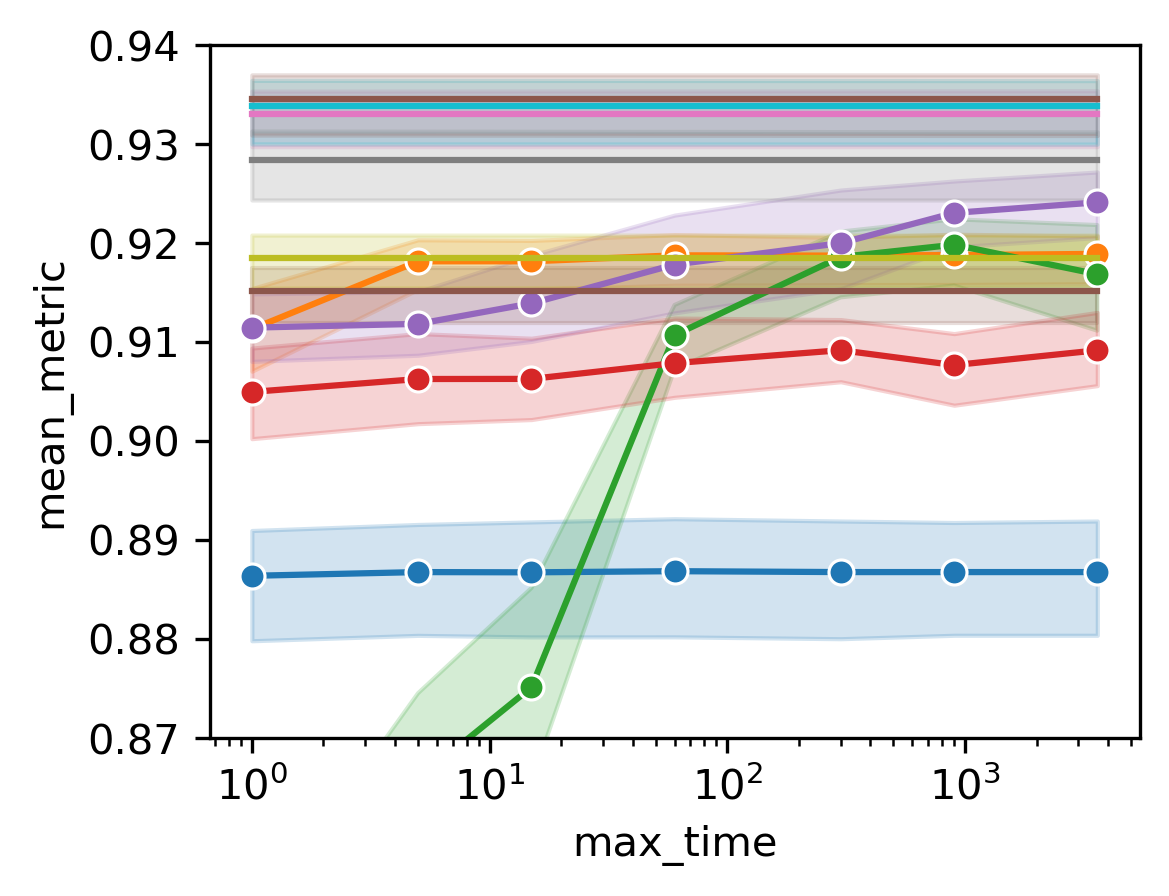

Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device


In [24]:
plt.figure(figsize=(4, 3), dpi=300)

compare_splits = remove_device_from_frame(results_df.groupby(["model", "split", "max_time"])['mean_metric'].mean().reset_index())

import seaborn as sns
varies_over_time = ['XGBoost', 'RF', 'MLP', 'KNN', 'LogReg']
compare_splits_varies = compare_splits[compare_splits.model.isin(varies_over_time)]
compare_splits_fixed = compare_splits[~compare_splits.model.isin(varies_over_time)]
hue_order = compare_splits_varies.model.unique().tolist() + compare_splits_fixed.model.unique().tolist()

color_palette = sns.color_palette()
# ax = sns.lineplot(data=compare_splits_varies, x="max_time", y="mean_metric", hue="model", errorbar="sd", marker="o", palette=color_palette[:len(varies_over_time)])
ax = sns.lineplot(data=compare_splits_varies, x="max_time", y="mean_metric", hue="model",  marker="o", palette=color_palette[:len(varies_over_time)])

compare_splits_fixed_dummy = compare_splits_fixed.copy()
compare_splits_fixed_dummy['max_time'] = compare_splits_varies.max_time.max()
sns.lineplot(data=pd.concat([compare_splits_fixed, compare_splits_fixed_dummy]),
             x="max_time", y="mean_metric", hue="model", ax=ax, palette=color_palette[len(varies_over_time):compare_splits.model.nunique()])
plt.xscale("log")
#legend = plt.legend(loc=(1.1 , .3))
legend = ax.get_legend()
legend.remove()
ax.set_ylim(0.87, 0.94)
plt.savefig("mean_auc_over_time_test_no_legend.pdf", bbox_inches="tight", pad_inches=0.0)

In [25]:
compare_splits_varies_last = compare_splits_varies[compare_splits_varies.max_time == compare_splits_varies.max_time.max()]

Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device


<Axes: xlabel='mean_metric', ylabel='model'>

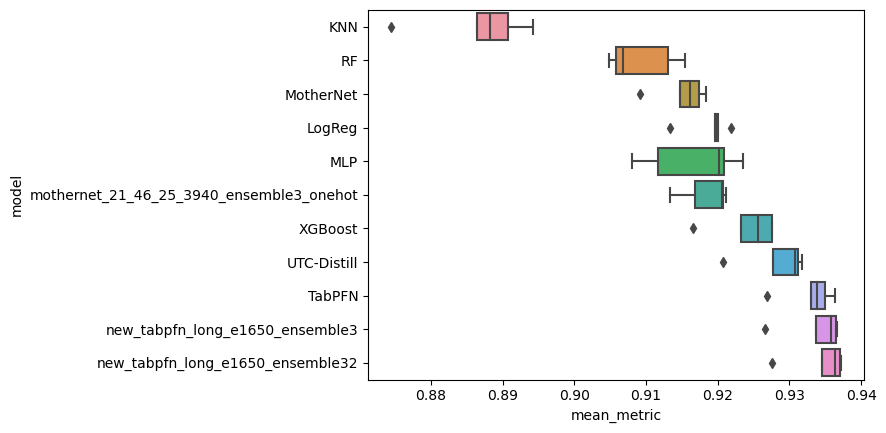

In [27]:
order = pd.concat([compare_splits_fixed, compare_splits_varies_last]).groupby("model").median("mean_metric").sort_values("mean_metric").index
sns.boxplot(data=pd.concat([compare_splits_fixed, compare_splits_varies_last]), y="model", x="mean_metric", order=order)

<Axes: xlabel='mean_metric', ylabel='model'>

Using a Transformer with 149.66 M parameters
Using cpu:0 device


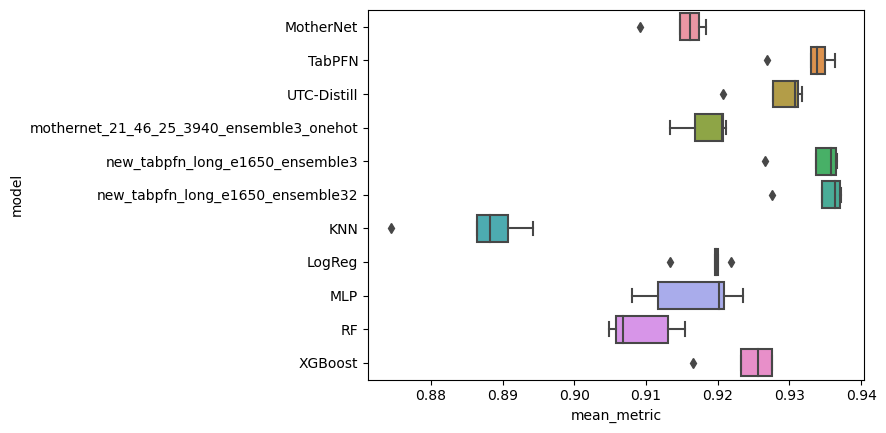

Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parame

In [26]:
sns.boxplot(data=pd.concat([compare_splits_fixed, compare_splits_varies_last]), y="model", x="mean_metric", hue_order=hue_order)

In [35]:
average_over_splits = results_df.groupby(["dataset", "model", "max_time"])[["mean_metric", "fit_time", "inference_time"]].mean().reset_index()

In [36]:
best_tuned = average_over_splits[average_over_splits.max_time == average_over_splits.max_time.max()]
untuned = average_over_splits[~average_over_splits.model.isin(best_tuned.model.unique())]
combined_best = pd.concat([best_tuned, untuned])

In [37]:
combined_best

,dataset,model,max_time,mean_metric,fit_time,inference_time
6,analcatdata_authorship,KNN,3600,0.999763,0.000296,0.003107
13,analcatdata_authorship,LogReg,3600,0.999965,0.122651,0.000233
20,analcatdata_authorship,MLP,3600,0.999935,2.108937,0.001859
29,analcatdata_authorship,RF,3600,0.999687,0.217911,0.027911
38,analcatdata_authorship,XGBoost,3600,0.999920,5.421059,0.029143
...,...,...,...,...,...,...
744,wdbc,TabPFN GPU,1,0.996465,0.000261,0.171985
745,wdbc,UTC-Distill GPU,1,0.994813,3.091072,0.000713
753,wdbc,mothernet_21_46_25_3940_ensemble3_onehot,1,0.996144,8.074254,0.020498
754,wdbc,new_tabpfn_long_e1650_ensemble3,1,0.996275,0.000311,0.198103


/anaconda/envs/fresh311/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


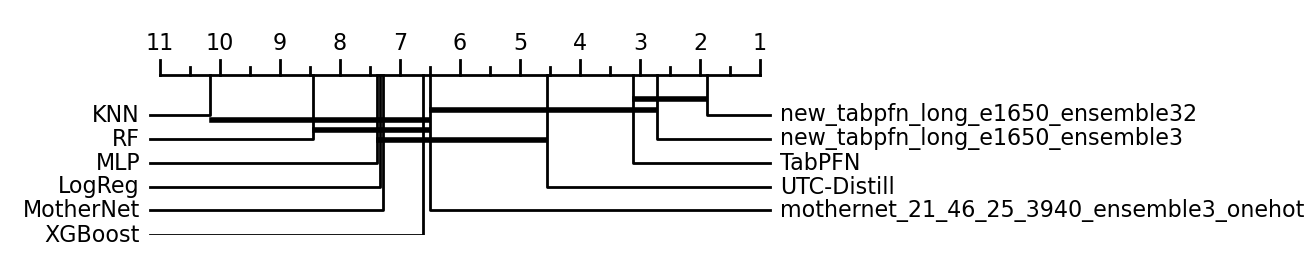

In [38]:
from tabpfn.scripts.critical_differences import draw_cd_diagram
res = draw_cd_diagram(remove_device_from_frame(combined_best), dataset_column="dataset", classifier_column="model", metric_column="mean_metric");
plt.savefig("cd_diagram_test.pdf", bbox_inches="tight", pad_inches=.15)

In [267]:
results_for_ranking = results_df.pivot(index="max_time", columns=["dataset", "split", "model"], values="mean_metric").ffill()

ranks_per_split_per_dataset = results_for_ranking.stack("model").unstack("max_time").rank(ascending=False)
average_ranks = ranks_per_split_per_dataset.stack("dataset").unstack("model").mean().reset_index(name="mean_rank")

In [268]:
# ax = sns.lineplot(data=average_ranks, x="max_time", y="mean_rank", hue="model", errorbar="sd", marker="o")
plt.figure(figsize=(4, 3), dpi=300)
ax = sns.lineplot(data=remove_device_from_frame(average_ranks), x="max_time", y="mean_rank", hue="model", marker="o", hue_order=hue_order)
ax.set_xscale("log")
#sns.move_legend(ax, (1.01, 0))
ax.set_ylabel("mean rank")
ax.set_xlabel("max time (s)")
legend = plt.legend(loc=(1.1 , .3))
legend.remove()
plt.savefig("rank_over_time_test_numeric_no_legend.pdf", bbox_inches="tight")

Bad pipe message: %s [b'k\xad\x0e\xd8m\xf2\xf9$\xc2\xe7\xbeZy\x17\xc4']
Bad pipe message: %s [b".\x8d\xa8\xe6\xf6?\xcd\xe1#Rx\xe5\x82xr\xdb\xb7\xee\x00\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0s\xc0w\x00\xc4\x00\xc3\xc0#\xc0'\x00g\x00@\xc0r\xc0v\x00\xbe\x00\xbd\xc0\n\xc0\x14\x009\x008\x00\x88\x00\x87\xc0\t\xc0\x13\x003\x002\x00\x9a\x00\x99\x00E\x00D\xc0\x07\xc0\x11\xc0\x08\xc0\x12\x00\x16\x00\x13\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00\xc0\x00<\x00\xba\x005\x00\x84\x00/"]
Bad pipe message: %s [b'\xdc%\xf8\xce\xda+\xfe\x0b.\xf8\xb3\x16\xd6\x14\x7f!\x1d\x0f\x00\x00>\xc0\x14\xc0\n\x009\x008\x007\x006\xc0\x0f\xc0\x05\x005\xc0\x13\xc0\t\x003\x002\x001\x000\xc0\x0e\xc0\x04\x00/\x00\x9a\x00\x99\x00']
Bad pipe message: %s [b'\\\x7f\x82]\x14\xc3\xb05T\x93\x9d\xb4\xd6F\xef\xc5;i\x00\x00>\xc0\x14\xc0\n

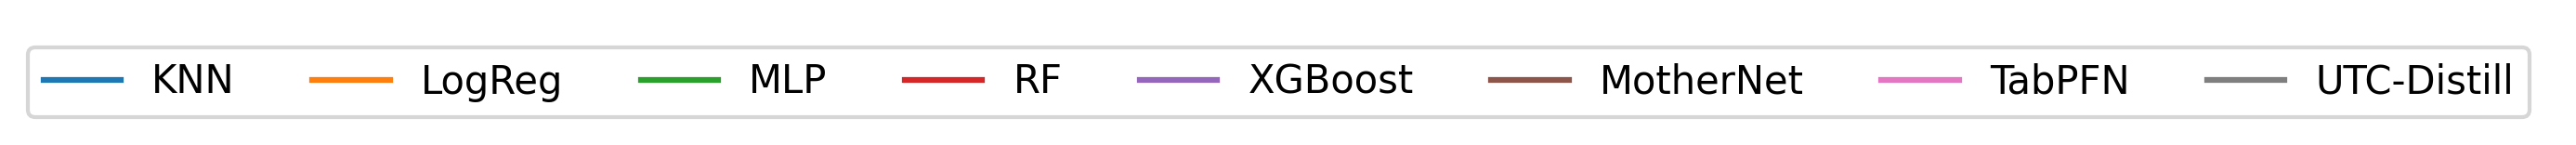

In [157]:
plt.figure(figsize=(10, .2), dpi=300)
ax = plt.gca()
ax.legend(legend.legendHandles, [t.get_text() for t in legend.texts], ncol=8)
ax.set_axis_off()
plt.savefig("legend.pdf", bbox_inches="tight")

In [230]:

combined_best = pd.concat([best_tuned, untuned])
combined_best = combined_best[~combined_best.model.isin(["tabpfn_post_mlflow", "distill_tabpfn_scaled"])].copy()
max_time = combined_best.max_time.max()

fig, axes = plt.subplots(1, 2, figsize=(9, 3), dpi=300)

combined_best['fit_and_predict_time'] = combined_best['fit_time'] + combined_best['inference_time']

#sns.scatterplot(data=combined_best, y="inference_time", x="fit_and_predict_time", hue="model", ax=axes[0], hue_order=["MotherNet", "TabPFN GPU", 'TabPFN-distill GPU', 'XGBoost', 'MotherNet GPU', "KNN", "LogReg", "RF", "MLP"])
sns.scatterplot(data=combined_best, y="inference_time", x="fit_and_predict_time", hue="model", ax=axes[0])
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_xlabel("fit + inference time (s)")
axes[0].set_ylabel("inference time (s)")
legend = axes[0].legend(loc=(1.01, 0))
#sns.move_legend(axes[0], (1.01, 0))

combined_best['fit_predict_tuning'] = combined_best['fit_and_predict_time'].copy()
#with_tuning = with_tuning[with_tuning.model.isin(["MotherNet", "TabPFN GPU", 'TabPFN-distill GPU', 'XGBoost', 'MotherNet GPU'])]
combined_best.fit_predict_tuning[with_tuning.model == "XGBoost"] = combined_best.fit_and_predict_time[with_tuning.model == "XGBoost"] + 30
combined_best.fit_predict_tuning[with_tuning.model == "MLP"] = combined_best.fit_and_predict_time[with_tuning.model == "MLP"] + 5 * 60
combined_best.fit_predict_tuning[with_tuning.model == "KNN"] = combined_best.fit_and_predict_time[with_tuning.model == "KNN"] + max_time
combined_best.fit_predict_tuning[with_tuning.model == "RF"] = combined_best.fit_and_predict_time[with_tuning.model == "RF"] + max_time
combined_best.fit_predict_tuning[with_tuning.model == "LogReg"] = combined_best.fit_and_predict_time[with_tuning.model == "LogReg"] + 15


#sns.scatterplot(data=with_tuning, y="inference_time", x="fit_and_predict_time", hue="model", ax=axes[1], hue_order=["MotherNet", "TabPFN GPU", 'TabPFN-distill GPU', 'XGBoost', 'MotherNet GPU'])
sns.scatterplot(data=combined_best, y="inference_time", x="fit_predict_tuning", hue="model", ax=axes[1])
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_xlabel("fit + inference time + tuning (s)")
axes[1].set_ylabel("inference time (s)")

axes[1].legend().remove()
plt.tight_layout()
plt.savefig("timing_comparison_two_panels_test.pdf")

/anaconda/envs/tabpfn/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/tabpfn/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/tabpfn/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/tabpfn/lib/python3.7/site-packages/ipykernel_launcher.py:23: Set

In [231]:
combined_best.set_index(['dataset', 'model']).unstack("model").fit_and_predict_time

model,KNN,LogReg,MLP,MotherNet CPU,MotherNet GPU,RF,TabPFN GPU,UTC-Distill GPU,XGBoost
dataset,,,,,,,,,
analcatdata_authorship,0.003403,0.122883,2.110796,4.563804,0.412486,0.245822,0.311527,3.967652,5.450201
balance-scale,0.002596,0.005586,3.867224,3.509384,0.354518,0.130538,0.038719,3.247113,6.888863
banknote-authentication,0.004147,0.015441,2.265630,5.589303,0.082742,0.137829,0.063518,5.132180,2.159731
blood-transfusion-service-center,0.002833,0.002096,4.294787,4.182153,0.063223,0.197757,0.065382,3.552801,1.168271
climate-model-simulation-crashes,0.002869,0.012909,6.137090,4.207329,0.035843,0.194027,0.082313,2.937308,2.164923
diabetes,0.003568,0.002885,2.889179,4.682818,0.108279,0.193765,0.066784,3.644721,2.482512
kc2,0.002686,0.015590,0.741304,3.363849,0.036514,0.201276,0.099611,2.893478,2.016383
mfeat-fourier,0.010263,1.419460,5.010222,6.772711,0.532664,0.346136,0.344995,8.065341,20.433646
mfeat-karhunen,0.010404,0.904632,28.779559,7.328387,0.445337,0.350309,0.367198,7.946200,15.373755


In [232]:
combined_best.set_index(['dataset', 'model']).unstack("model").fit_predict_tuning

model,KNN,LogReg,MLP,MotherNet CPU,MotherNet GPU,RF,TabPFN GPU,UTC-Distill GPU,XGBoost
dataset,,,,,,,,,
analcatdata_authorship,3600.003403,15.122883,302.110796,4.563804,0.412486,3600.245822,0.311527,3.967652,35.450201
balance-scale,3600.002596,15.005586,303.867224,3.509384,0.354518,3600.130538,0.038719,3.247113,36.888863
banknote-authentication,3600.004147,15.015441,302.265630,5.589303,0.082742,3600.137829,0.063518,5.132180,32.159731
blood-transfusion-service-center,3600.002833,15.002096,304.294787,4.182153,0.063223,3600.197757,0.065382,3.552801,31.168271
climate-model-simulation-crashes,3600.002869,15.012909,306.137090,4.207329,0.035843,3600.194027,0.082313,2.937308,32.164923
diabetes,3600.003568,15.002885,302.889179,4.682818,0.108279,3600.193765,0.066784,3.644721,32.482512
kc2,3600.002686,15.015590,300.741304,3.363849,0.036514,3600.201276,0.099611,2.893478,32.016383
mfeat-fourier,3600.010263,16.419460,305.010222,6.772711,0.532664,3600.346136,0.344995,8.065341,50.433646
mfeat-karhunen,3600.010404,15.904632,328.779559,7.328387,0.445337,3600.350309,0.367198,7.946200,45.373755


In [233]:
inference_time = combined_best.set_index(['dataset', 'model']).unstack("model").inference_time
inference_time_speedup = (inference_time.divide(inference_time['XGBoost'], axis='rows') ** -1).mean()

fit_and_predict_time = combined_best.set_index(['dataset', 'model']).unstack("model").fit_and_predict_time
fit_predict_speedup = (fit_and_predict_time.divide(fit_and_predict_time['XGBoost'], axis='rows') ** -1).mean()

fit_predict_tuning = combined_best.set_index(['dataset', 'model']).unstack("model").fit_predict_tuning
fit_predict_tuning_speedup = (fit_predict_tuning.divide(fit_predict_tuning['XGBoost'], axis='rows') ** -1).mean()


In [234]:
fit_and_predict_time.mean()

model
KNN                0.005287
LogReg             0.257996
MLP                6.233925
MotherNet CPU      5.310225
MotherNet GPU      0.219055
RF                 0.243274
TabPFN GPU         0.178517
UTC-Distill GPU    5.196254
XGBoost            5.645028
dtype: float64

In [235]:
fit_predict_tuning

model,KNN,LogReg,MLP,MotherNet CPU,MotherNet GPU,RF,TabPFN GPU,UTC-Distill GPU,XGBoost
dataset,,,,,,,,,
analcatdata_authorship,3600.003403,15.122883,302.110796,4.563804,0.412486,3600.245822,0.311527,3.967652,35.450201
balance-scale,3600.002596,15.005586,303.867224,3.509384,0.354518,3600.130538,0.038719,3.247113,36.888863
banknote-authentication,3600.004147,15.015441,302.265630,5.589303,0.082742,3600.137829,0.063518,5.132180,32.159731
blood-transfusion-service-center,3600.002833,15.002096,304.294787,4.182153,0.063223,3600.197757,0.065382,3.552801,31.168271
climate-model-simulation-crashes,3600.002869,15.012909,306.137090,4.207329,0.035843,3600.194027,0.082313,2.937308,32.164923
diabetes,3600.003568,15.002885,302.889179,4.682818,0.108279,3600.193765,0.066784,3.644721,32.482512
kc2,3600.002686,15.015590,300.741304,3.363849,0.036514,3600.201276,0.099611,2.893478,32.016383
mfeat-fourier,3600.010263,16.419460,305.010222,6.772711,0.532664,3600.346136,0.344995,8.065341,50.433646
mfeat-karhunen,3600.010404,15.904632,328.779559,7.328387,0.445337,3600.350309,0.367198,7.946200,45.373755


In [236]:
with pd.option_context("display.float_format", lambda x: f"{x:.1f}"):
    display(pd.DataFrame({'predict':inference_time_speedup, 'fit+predict': fit_predict_speedup, 'fit+predict+tuning': fit_predict_tuning_speedup}).T)

model,KNN,LogReg,MLP,MotherNet CPU,MotherNet GPU,RF,TabPFN GPU,UTC-Distill GPU,XGBoost
predict,5.0,98.9,13.6,2.7,4.3,0.8,0.2,21.3,1.0
fit+predict,1063.0,201.1,1.5,1.0,36.3,22.0,40.4,1.0,1.0
fit+predict+tuning,0.0,2.3,0.1,7.0,335.4,0.0,310.2,7.6,1.0


In [237]:
with pd.option_context("display.float_format", lambda x: f"{x:.1f}"):
    print(pd.DataFrame({'predict':inference_time_speedup, 'fit+predict': fit_predict_speedup, 'fit+predict+tuning': fit_predict_tuning_speedup}).T.to_latex())

\begin{tabular}{lrrrrrrrrr}
\toprule
model &    KNN &  LogReg &  MLP &  MotherNet CPU &  MotherNet GPU &   RF &  TabPFN GPU &  UTC-Distill GPU &  XGBoost \\
\midrule
predict            &    5.0 &    98.9 & 13.6 &            2.7 &            4.3 &  0.8 &         0.2 &             21.3 &      1.0 \\
fit+predict        & 1063.0 &   201.1 &  1.5 &            1.0 &           36.3 & 22.0 &        40.4 &              1.0 &      1.0 \\
fit+predict+tuning &    0.0 &     2.3 &  0.1 &            7.0 &          335.4 &  0.0 &       310.2 &              7.6 &      1.0 \\
\bottomrule
\end{tabular}



In [239]:
with pd.option_context("display.float_format", lambda x: f"{x:.2f}"):
    print(pd.DataFrame({'predict':inference_time_speedup, 'fit+predict': fit_predict_speedup, 'fit+predict+tuning': fit_predict_tuning_speedup}).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  predict &  fit+predict &  fit+predict+tuning \\
model           &          &              &                     \\
\midrule
KNN             &     5.02 &      1062.99 &                0.01 \\
LogReg          &    98.89 &       201.14 &                2.33 \\
MLP             &    13.64 &         1.51 &                0.12 \\
MotherNet CPU   &     2.68 &         1.01 &                7.00 \\
MotherNet GPU   &     4.28 &        36.29 &              335.43 \\
RF              &     0.85 &        22.05 &                0.01 \\
TabPFN GPU      &     0.18 &        40.45 &              310.16 \\
UTC-Distill GPU &    21.27 &         1.03 &                7.63 \\
XGBoost         &     1.00 &         1.00 &                1.00 \\
\bottomrule
\end{tabular}



In [51]:
compare

model,XGBoost,mothernet_21_46_25_3940_ensemble3_onehot,new_tabpfn_long_e1650_ensemble3
dataset,,,
analcatdata_authorship,0.999928,0.999189,0.999986
balance-scale,0.990811,0.994119,0.996432
banknote-authentication,0.999995,1.000000,1.000000
blood-transfusion-service-center,0.736017,0.758999,0.753801
climate-model-simulation-crashes,0.928573,0.949182,0.952226
diabetes,0.839657,0.842772,0.844434
kc2,0.827621,0.833803,0.830990
mfeat-fourier,0.979313,0.946621,0.982912
mfeat-karhunen,0.997947,0.967746,0.998619


In [45]:
results_df.dataset.unique()

array(['balance-scale', 'mfeat-fourier', 'mfeat-karhunen',
       'mfeat-morphological', 'mfeat-zernike', 'diabetes', 'vehicle',
       'analcatdata_authorship', 'pc4', 'pc3', 'kc2', 'pc1',
       'banknote-authentication', 'blood-transfusion-service-center',
       'qsar-biodeg', 'wdbc', 'steel-plates-fault',
       'climate-model-simulation-crashes'], dtype=object)

In [28]:
bla = results_df.groupby(["model", "dataset", "max_time"])['mean_metric'].mean().reset_index()

In [29]:
bla.model.unique()

array(['KNN', 'LogReg', 'MLP', 'MotherNet CPU', 'MotherNet GPU', 'RF',
       'TabPFN GPU', 'UTC-Distill GPU', 'XGBoost',
       'mothernet_21_46_25_3940_ensemble3_onehot',
       'new_tabpfn_long_e1650_ensemble3',
       'new_tabpfn_long_e1650_ensemble32'], dtype=object)

In [39]:
filtered = bla[bla.model.isin(["new_tabpfn_long_e1650_ensemble3", "XGBoost", "mothernet_21_46_25_3940_ensemble3_onehot"])]

In [40]:
with_max_time = filtered.groupby(["model", "dataset"]).max().reset_index()

In [41]:
compare = with_max_time.pivot(index="dataset", columns="model", values="mean_metric")

In [52]:
#different = compare[np.abs(compare.diff(axis=1).iloc[:, 1]) > 0.01]

<Axes: ylabel='dataset'>

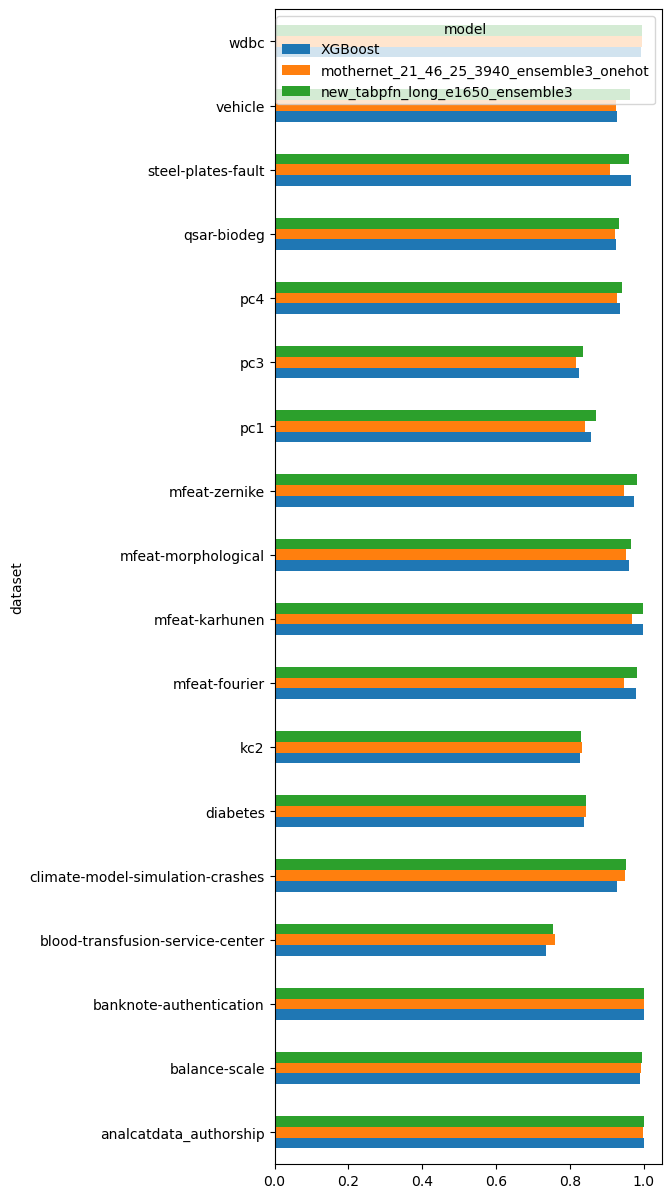

Bad pipe message: %s [b'\xca\x8a\xd1\x0e\xa6\xc5\xe0\x16[\\\xe6jpN*\xff\xce\xc6 \nPY\x1d\xb7g\xcaC\x98}\x12)\x87-"\xa2-\xaa\x9a%\x04\xe7^\xcd\xe1k\x1b\xfa\xd1\x0b+\xbc\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05']
Bad pipe message: %s [b'\x04\x01\x05\x01\x06\x01\x00']
Bad pipe message: %s [b'RP\x07\xa0\n\xced\x10e\x0f\xc0\xa5\xeea\xe9\x0c.\x95 \x91\xf7\x93\xe8e=\x03\x05\xbe\xb7\xb2\x86\n\x9e\xef\x8f\x1f9\x04\xd5\xd5b\x8c? F:M^\xd9?\xc4\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00']
Bad pipe message: %s [b'\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 9b\x13\xf3\xcd\xaf\x18\x80\x804\x9e\xd1\xd2\x8fR\xdee\xce\xc3\xf6\xf5\x06']


In [54]:
plt.figure(figsize=(5, 15))
compare.plot.barh(ax=plt.gca())